In [119]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initial Data Load and Transformation

In [122]:
productiondatafile = 'D:/Git/Frack Hits/Production Data.csv'
welldatafile = 'D:/Git/Frack Hits/Well Geolocation and Frac Dates.csv'

prod = pd.read_csv(productiondatafile).iloc[:,1:]
prod['Date'] = pd.to_datetime(prod['Date'])
prod =  prod.rename(columns = {'Down Time Hours':'DT','Oil BBL':'Oil','Water BBL':'Water'})

WHM = pd.read_csv(welldatafile).iloc[:,1:]
WHM['Frac Start Date'] = pd.to_datetime(WHM['Frac Start Date'])
WHM['Frac End Date'] = pd.to_datetime(WHM['Frac End Date'])

###Remove when datset cleaned

#Project lat/long to x/y plane based on median lat/long location
#Radius of Earth is ~3959 miles
medLat = WHM['Lat'].median()
WHM['x_coord'] = np.divide(3959 * np.cos(np.divide(medLat * np.pi,180) ) * WHM['Long'] * np.pi , 180)
WHM['y_coord'] = np.divide(WHM['Lat'] * 3959 * np.pi, 180)

#Self-crossjoin to get pairwise well distances
dist = WHM[['WellID','x_coord','y_coord']]
distances = dist.assign(foo=1).merge(dist.assign(foo=1),on='foo').drop('foo',axis=1)
#Remove self-joined wells and left-side wells not included in production data
distances = distances[(distances['WellID_x']!=distances['WellID_y']) & \
                      (distances['WellID_x'].isin(prod['WellID'].unique()))]
distances['dist'] = np.sqrt(np.power(distances['x_coord_x'] - distances['x_coord_y'],2) +\
        np.power(distances['y_coord_x'] - distances['y_coord_y'],2))
distances = distances[['WellID_x','WellID_y','dist']]
distances.columns = ['WellID','WellID2','dist']


#Un-Pivoted table for frack dates
startprod = prod['Date'].min()
lastprod = prod['Date'].max()
Calendar = pd.DataFrame(pd.date_range(startprod,lastprod), columns=['Date'])
frackdates = WHM[['WellID','Frac Start Date','Frac End Date']].assign(foo=1)\
                .merge(Calendar.assign(foo=1), on='foo').drop('foo',axis=1)
frackdates.loc[(frackdates['Frac Start Date']<=frackdates['Date']) &\
               (frackdates['Frac End Date']>=frackdates['Date']),\
               'fracking?'] = 1
frackdates = frackdates[(frackdates.Date >= startprod) & (frackdates['fracking?'] == 1)]

#Full Calendar for wells, including non-prod days
wellCal = pd.DataFrame(columns=['WellID','Date'])
firstprodlist = prod[prod.Oil>1][['WellID','Date']].groupby('WellID').min()
lastprodlist = prod[['WellID','Date']].groupby('WellID').max()
for w in firstprodlist.index:
    wellCal = wellCal.append(pd.DataFrame(\
            {'WellID': w , 'Date': pd.date_range(firstprodlist.at[w ,'Date'], lastprodlist.at[w ,'Date']) }))

# Functions for transforming the data

In [123]:
#build nearby fracks column
def nearbyfracking(distances, frackdates, offset):
    neardist = distances[(distances['dist']<=offset) & (distances['WellID']!=distances['WellID2'])].drop('dist',axis=1)
    
    #Merge well fracking time period with all nearby wells within offset distance
    nearbyfrackswwells = frackdates.merge(neardist, left_on='WellID', right_on='WellID2')\
                    .drop(labels=['WellID2'], axis=1)\
                    .rename(columns={'WellID_x':'WellID2','WellID_y':'WellID'})\
                    [['WellID','Date','fracking?','WellID2']]
    nearbyfracks = nearbyfrackswwells.drop('WellID2',axis=1).groupby(by=['WellID','Date']).sum()
    nearbyfracks.columns = ['nearbyfracks at {}'.format(offset)]
    nearbyfrackswwells = nearbyfrackswwells.astype({'WellID':'int64', 'WellID2':'int64'})
    nearbyfracks = nearbyfracks.reset_index().astype({'WellID':'int64'})
    return nearbyfracks, nearbyfrackswwells.drop('fracking?',axis=1)


#Merge production with nearby fracks
#Need to merge in complete calendar to get offset fracks, then remove those non-prod days again
def merge_fracksprod(prod, nearbyfracks):
    prodf = prod[['WellID','Date','DT','Oil']].merge(wellCal, how='right').copy()
    prodf['prodday'] = np.where((prodf['DT']<24) & (prodf['Oil']>1),1,0)
    #Index dates by count of producing days
    prodf['proddayIndex'] = prodf[['WellID','Date','prodday']].sort_values('Date').groupby(['WellID']).cumsum()
    #Merge in # nearby fracking wells for each date
    merged1 = prodf[['WellID','Date','proddayIndex']]\
        .merge(nearbyfracks, left_on = ['WellID','Date'], right_on=['WellID','Date'], how='left')\
        .drop(labels=['Date'],axis=1)
    #Re-align nearby well fracking counts from Calendar Date to Production Day index
    #(since wells are often not producing during nearby fracs)
    ####Try to reduce mem. Only include Oil > 1
    prodf = prodf[prodf.Oil > 1]
    merged2 =prodf.merge(merged1,left_on = ['WellID','proddayIndex'],right_on = ['WellID','proddayIndex'], how='left')\
        .groupby(['WellID','Date']).max().drop(labels=['prodday'], axis=1).reset_index()
    return merged2


#Parallel operation to merge_fracksprod, except including IDs of nearby wells, to identify culprit wells for frac hits
def merge_fracksprod_wwells(prod, nearbyfrackswwells):
    prodf = prod[['WellID','Date','DT','Oil']].merge(wellCal, how='right').copy()
    prodf['prodday'] = np.where((prodf['DT']<24) & (prodf['Oil']>1),1,0)
    #Index dates by count of producing days
    prodf['proddayIndex'] = prodf[['WellID','Date','prodday']].sort_values('Date').groupby(['WellID']).cumsum()
    #Merge in each nearby fracking well for each date
    merged1wwells = prodf[['WellID','Date','proddayIndex']]\
        .merge(nearbyfrackswwells, left_on = ['WellID','Date'], right_on=['WellID','Date'], how='left')\
        .drop(labels=['Date'],axis=1)
    #Re-align nearby well fracking counts from Calendar Date to Production Day index
    #(since wells are often not producing during nearby fracs)
    merged2wwells =prodf.drop('Oil', axis=1)\
        .merge(merged1wwells,left_on = ['WellID','proddayIndex'],right_on = ['WellID','proddayIndex'], how='left')\
        .groupby(['WellID','Date','WellID2']).min().drop(labels=['DT','prodday'], axis=1).reset_index()
    return merged2wwells[~merged2wwells['WellID2'].isnull()].astype({'WellID2':'int64'})

#Add a few extra calendar days to frac time window, just in case hits arrive later, or data quality is low
def extendfrackdates(df, length):
    df3 = df.copy()
    for i in range(length):
        df2 = df.copy()
        df2['proddayIndex'] = df2['proddayIndex'] + i+1
        df3 = df3.append(df2)
    df3 = df3.groupby(['WellID','proddayIndex']).max().reset_index()
    return df3
def extendfrackdateswwells(df, length):
    df3 = df.copy()
    for i in range(length):
        df2 = df.copy()
        df2['proddayIndex'] = df2['proddayIndex'] + i+1
        df3 = df3.append(df2)
    df3 = df3.groupby(['WellID','proddayIndex','WellID2']).max().reset_index()
    return df3

#Make window for calculating Oil, Water, and Water/Oil ratio - Mean and Std. Dev.
def prevProdCharacteristics(df, bw, sw):
    shift = [sw, bw]
    #disregard days on wells which have 12 or more hours of downtime
    df2 = df[df.DT < 12].copy()
    df2['Water/Oil'] = np.divide(df2['Water'],np.maximum(1,df2['Oil']))
    joined = pd.DataFrame()
    
    #Can I use groupby for this?
    for ID in df2['WellID'].unique():
        wellframe = df2[['WellID','Date','Water','Water/Oil']][df2['WellID'] == ID]\
        .drop('WellID',axis=1).set_index('Date')
        for i in shift:
            wellframe['Water {}-day mean'.format(i)] = wellframe['Water'].rolling(i, min_periods=min(i,7)).mean()
            wellframe['Water {}-day std'.format(i)] = wellframe['Water'].rolling(i, min_periods=min(i,7)).std()
            wellframe['Water/Oil {}-day mean'.format(i)] = wellframe['Water/Oil'].rolling(i, min_periods=min(i,7)).mean()
            wellframe['Water/Oil {}-day std'.format(i)] = wellframe['Water/Oil'].rolling(i, min_periods=min(i,7)).std()
        wellframe['WellID'] = ID
        wellframe.drop(['Water/Oil','Water'], axis=1, inplace=True)
        wellframe.reset_index(inplace=True)
        joined = pd.concat([joined, wellframe], axis=0, sort=False)
    joined = df.merge(joined, left_on=['WellID','Date'], right_on=['WellID','Date'])
    return joined

# Step by Step calculation and Parameter Assignment

In [151]:
#radial distance from wellhead to scan for offset fracks (in miles)
offset = 2
# #of previous days to average and std-dev production trends
bigwindow = 30
bw = bigwindow #brevity
# number of days to measure for triggering frack hit event (1 might be most appropriate)
smallwindow = 2
sw = smallwindow #brevity

nearbyfracks, nearbyfrackswwells = nearbyfracking(distances, frackdates, offset)
mergingfracks = merge_fracksprod(prod, nearbyfracks)
prodwfracks_pre = prod.merge(mergingfracks, how = 'left')
prodwfracks = prodwfracks_pre.drop('nearbyfracks at {}'.format(offset), axis=1)\
    .merge(extendfrackdates(prodwfracks_pre[['WellID','proddayIndex','nearbyfracks at {}'.format(offset)]], 4)\
    .groupby(['WellID','proddayIndex']).max().reset_index())
charDF = prevProdCharacteristics(prodwfracks, bigwindow, smallwindow)

# Frac Hit Detector

In [125]:
#Use prevProdCharacteristics function to provide windowing columns
def findfrackhits(df0, bw=bigwindow, sw=smallwindow):
    volmult = 2
    ratiomult = 2
    df = df0.copy()
    
    #Trigger for frac hit based on total Water volume
    df['frackhitvol'] = np.where(df['Water {}-day mean'.format(sw)]>df['Water {}-day mean'.format(bw)]+\
        df['Water {}-day std'.format(bw)]*volmult, 1, 0)*np.minimum(df['nearbyfracks at {}'.format(offset)],1)
    #Trigger for frac hit based on Water/Oil ratio
    df['frackhitratio'] = np.where(df['Water/Oil {}-day mean'.format(sw)]>df['Water/Oil {}-day mean'.format(bw)] +\
         df['Water/Oil {}-day std'.format(bw)]*ratiomult, 1, 0)*np.minimum(df['nearbyfracks at {}'.format(offset)],1)
    #Combine triggers
    df['frackhit'] = (df['frackhitvol'] + df['frackhitratio']) / 2
    return df[df['frackhit']>=0.5][['WellID','Date','frackhit','frackhitvol','frackhitratio']]

In [152]:
#Show nearest fracking well on each recorded frack hit
frackhits = findfrackhits(charDF)

#Remove duplicated frack hits in 7-day window: Aggregate vol and ratio values
f = frackhits.merge(frackhits[['WellID','Date']], on=['WellID'], how='left' )
f = f[(f['Date_y'] <= f['Date_x']) & (f['Date_y'] >= f['Date_x'] - pd.Timedelta(days=7))]

fdate = pd.DataFrame(f.groupby(['WellID','Date_x']).min()['Date_y']).reset_index()
ffull = fdate.merge(f.drop('Date_y',axis=1), how='outer',on=['WellID','Date_x'])
frackhits = pd.DataFrame(ffull.groupby(['WellID','Date_y']).max()\
                     [['frackhit','frackhitvol','frackhitratio']]).reset_index()\
                .rename(columns = {'Date_y':'Date'})

#Confirm # of hits detected
frackhits.shape

(690, 5)

In [158]:
wells = prod.WellID.unique()
wells = [well for well in wells if well not in frackhits.WellID.unique()]
lesswells = [well for well in wells if np.random.rand() <= 0.75]

In [ ]:
smallprod = prod[~prod['WellID'].isin(lesswells)]
smallprod.to_csv('D:/Git/Frack Hits/Production Data_small.csv')

# Plots for displaying frack hits

In [112]:
def plotfrackhit(df,frackhits, startpad = -60, endpad = 40, offset=offset):
    if isinstance(frackhits, pd.DataFrame):
        mindate = frackhits['Date'].min()
        maxdate = frackhits['Date'].max()
    else:
        mindate =  frackhits['Date']
        maxdate = frackhits['Date']
    well = np.min(frackhits['WellID'])
    df = df[df.WellID==well]
    
    minproddate = max(df.proddayIndex.min(), df[df['Date']==mindate]['proddayIndex'].min() + startpad)
    maxproddate = min(df.proddayIndex.max(), df[df['Date']==maxdate]['proddayIndex'].max() + endpad)
    startdate =  df[df['proddayIndex']==minproddate]['Date'].min()
    enddate = min(df[df['proddayIndex']==maxproddate+endpad]['Date'].max(),df.Date.max())
    df = df[(df['proddayIndex']>= minproddate) & (df['proddayIndex']<=maxproddate)]
    cal = pd.DataFrame(pd.date_range(startdate,enddate), columns=['Date'])
    df = df.merge(cal, how='right')\
        [['WellID','Date','Oil','nearbyfracks at {}'.format(offset),'Water','Water/Oil {}-day mean'.format(sw)]]\
        .sort_values(by='Date')
    df[['Oil','Water']] = df[['Oil','Water']].fillna(0)
    df['nearbyfracks at {}'.format(offset)] = df['nearbyfracks at {}'.format(offset)].fillna(method='ffill')
    
    x = df['Date']
    y1 = df['Oil']
    y2 = df['nearbyfracks at {}'.format(offset)]
    y3 = df['Water']
    y4 = df['Water/Oil {}-day mean'.format(sw)]

    fig, ax1 = plt.subplots(figsize=(50,20))
    plt.xticks(fontsize=30, rotation=45)
    plt.yticks(fontsize=20)
    ax2 = ax1.twinx()
    plt.title('Well ID: {}'.format(well), fontdict= {'fontsize':40})
    plt.ylim(0,max(y1.max(),y3.max()))
    ax1.plot(x, y1, 'black', label = 'Oil')
    ax1.plot(x, y3, 'blue', label = 'Water')
    ax1.xaxis.grid(True, which='both')
    ax1.tick_params(which='major', length=7)
    ax1.legend(prop={'size': 30})

    ax2.plot(x, y2, 'orange', label = '# of nearby fracks')
    ax2.plot(x, y4, 'green', label = 'Water/Oil ratio')
    ax2.legend(prop={'size': 30} , loc = 'upper left')
    plt.yticks(fontsize=20)
    ax2.set_ylim([0,y2.max() * 2])
    if isinstance(frackhits, pd.DataFrame):
        for i in frackhits['Date']:
            plt.axvline(i, color = 'red', lw = 3)
    else:
        plt.axvline(frackhits['Date'], color = 'red', lw = 3)

def showfrackhitplot(df,frackhits, startpad = -60, endpad = 40, offset=offset):
    plotfrackhit(df,frackhits, startpad = -60, endpad = 40, offset=offset)
    plt.show()

def savefrackhitplot(filename, df,frackhits, startpad = -40, endpad = 40, offset=offset):
    plotfrackhit(df,frackhits, startpad = -60, endpad = 40, offset=offset)
    plt.savefig(filename)
    plt.close()

def saveplotfrackhit(filename, df,frackhits, startpad = -40, endpad = 40, offset=offset):
    if isinstance(frackhits, pd.DataFrame):
        mindate = frackhits['Date'].min()
        maxdate = frackhits['Date'].max()
    else:
        mindate =  frackhits['Date']
        maxdate = frackhits['Date']
    well = np.min(frackhits['WellID'])
    
    df = df[df.merrickid==merrick]
    minproddate = max(df.proddayIndex.min(), df[df['Date']==mindate]['proddayIndex'].min() + startpad)
    maxproddate = min(df.proddayIndex.max(), df[df['Date']==maxdate]['proddayIndex'].max() + endpad)
    startdate =  df[df['proddayIndex']==minproddate]['Date'].min()
    enddate = min(df[df['proddayIndex']==maxproddate+endpad]['Date'].max(),df.Date.max())
    df = df[(df['proddayIndex']>= minproddate) & (df['proddayIndex']<=maxproddate)]
    cal = pd.DataFrame(pd.date_range(startdate,enddate), columns=['Date'])
    df = df.merge(cal, how='right')\
        [['WellID','Date','Oil','nearbyfracks at {}'.format(offset),'Water','Water/Oil {}-day mean'.format(sw)]]\
        .sort_values(by='Date')
    df[['Oil','Water']] = df[['Oil','Water']].fillna(0)
    df['nearbyfracks at {}'.format(offset)] = df['nearbyfracks at {}'.format(offset)].fillna(method='ffill')

    x = df['Date']
    y1 = df['Oil']
    y2 = df['nearbyfracks at {}'.format(offset)]
    y3 = df['Water']
    y4 = df['Water/Oil {}-day mean'.format(sw)]

    fig, ax1 = plt.subplots(figsize=(50,20))
    plt.xticks(fontsize=30, rotation=45)
    plt.yticks(fontsize=20)
    ax2 = ax1.twinx()
    plt.title('Well ID: {}'.format(well), fontdict= {'fontsize':40})
    plt.ylim(0,max(y1.max(),y3.max()))
    ax1.plot(x, y1, 'black', label = 'Oil')
    ax1.plot(x, y3, 'blue', label = 'Water')
    ax1.xaxis.grid(True, which='both')
    ax1.tick_params(which='major', length=7)
    ax1.legend(prop={'size': 30})

    ax2.plot(x, y2, 'orange', label = '# of nearby fracks')
    ax2.plot(x, y4, 'green', label = 'Water/Oil ratio')
    ax2.legend(prop={'size': 30} , loc = 'upper left')
    plt.yticks(fontsize=20)
    ax2.set_ylim([0,y2.max() * 2])
    
    if isinstance(frackhits, pd.DataFrame):
        for i in frackhits['Date']:
            plt.axvline(i, color = 'red', lw = 3)
    else:
        plt.axvline(frackhits['Date'], color = 'red', lw = 3)
    plt.savefig(filename)
    plt.close()

def saveplotfrackhit_old(filename, df,frackhits, startpad = -40, endpad = 40, offset=offset):
    if isinstance(frackhits, pd.DataFrame):
        mindate = frackhits['Date'].min()
        maxdate = frackhits['Date'].max()
    else:
        mindate =  frackhits['Date']
        maxdate = frackhits['Date']
    well = np.min(frackhits['WellID'])
    
    df = df[df.merrickid==merrick]
    minproddate = max(df.proddayIndex.min(), df[df['Date']==mindate]['proddayIndex'].min() + startpad)
    maxproddate = min(df.proddayIndex.max(), df[df['Date']==maxdate]['proddayIndex'].max() + endpad)
    startdate =  df[df['proddayIndex']==minproddate]['Date'].min()
    enddate = min(df[df['proddayIndex']==maxproddate+endpad]['Date'].max(),df.Date.max())
    df = df[(df['proddayIndex']>= minproddate) & (df['proddayIndex']<=maxproddate)]
    cal = pd.DataFrame(pd.date_range(startdate,enddate), columns=['Date'])
    df = df.merge(cal, how='right')\
        [['WellID','Date','Oil','nearbyfracks at {}'.format(offset),'Water','Water/Oil {}-day mean'.format(sw)]]\
        .sort_values(by='Date')
    df[['Oil','Water']] = df[['Oil','Water']].fillna(0)
    df['nearbyfracks at {}'.format(offset)] = df['nearbyfracks at {}'.format(offset)].fillna(method='ffill')

    x = df['Date']
    y1 = df['Oil']
    y2 = df['nearbyfracks at {}'.format(offset)]
    y3 = df['Water']
    y4 = df['Water/Oil {}-day mean'.format(sw)]

    fig, ax1 = plt.subplots(figsize=(50,20))
    plt.xticks(fontsize=30, rotation=45)
    plt.yticks(fontsize=20)
    ax2 = ax1.twinx()
    plt.title('Well ID: {}'.format(well), fontdict= {'fontsize':40})
    plt.ylim(0,max(y1.max(),y3.max()))
    ax1.plot(x, y1, 'black', label = 'Oil')
    ax1.plot(x, y3, 'blue', label = 'Water')
    ax1.xaxis.grid(True, which='both')
    ax1.tick_params(which='major', length=7)
    ax1.legend(prop={'size': 30})
    

    ax2.plot(x, y2, 'orange', label = '# of nearby fracks')
    ax2.plot(x, y4, 'green', label = 'Water/Oil ratio')
    ax2.legend(prop={'size': 30} , loc = 'upper left')
    plt.yticks(fontsize=20)
    ax2.set_ylim([0,y2.max() * 2])
    
    if isinstance(frackhits, pd.DataFrame):
        for i in frackhits['Date']:
            plt.axvline(i, color = 'red', lw = 3)
    else:
        plt.axvline(frackhits['Date'], color = 'red', lw = 3)
    plt.savefig(filename)
    plt.close()

In [114]:
#Optional steps for informing which wells could have caused each frac hit

proddaysandfrackingwells_pre = merge_fracksprod_wwells(prod, nearbyfrackswwells)
proddaysandfrackingwells = prodwfracks.drop('nearbyfracks at {}'.format(offset), axis=1)\
        .merge(extendfrackdateswwells(proddaysandfrackingwells_pre.drop('Date',axis=1), 4))

#Add culprit wells to Frackhits List
proddays_frackwells_dist = proddaysandfrackingwells.merge(distances\
                               ,left_on=['WellID','WellID2'],right_on=['WellID','WellID2'])
frackhits_culpritwells = frackhits.merge(proddays_frackwells_dist[['WellID','Date','WellID2','dist']], how='left')

# PLOT FRACK HIT

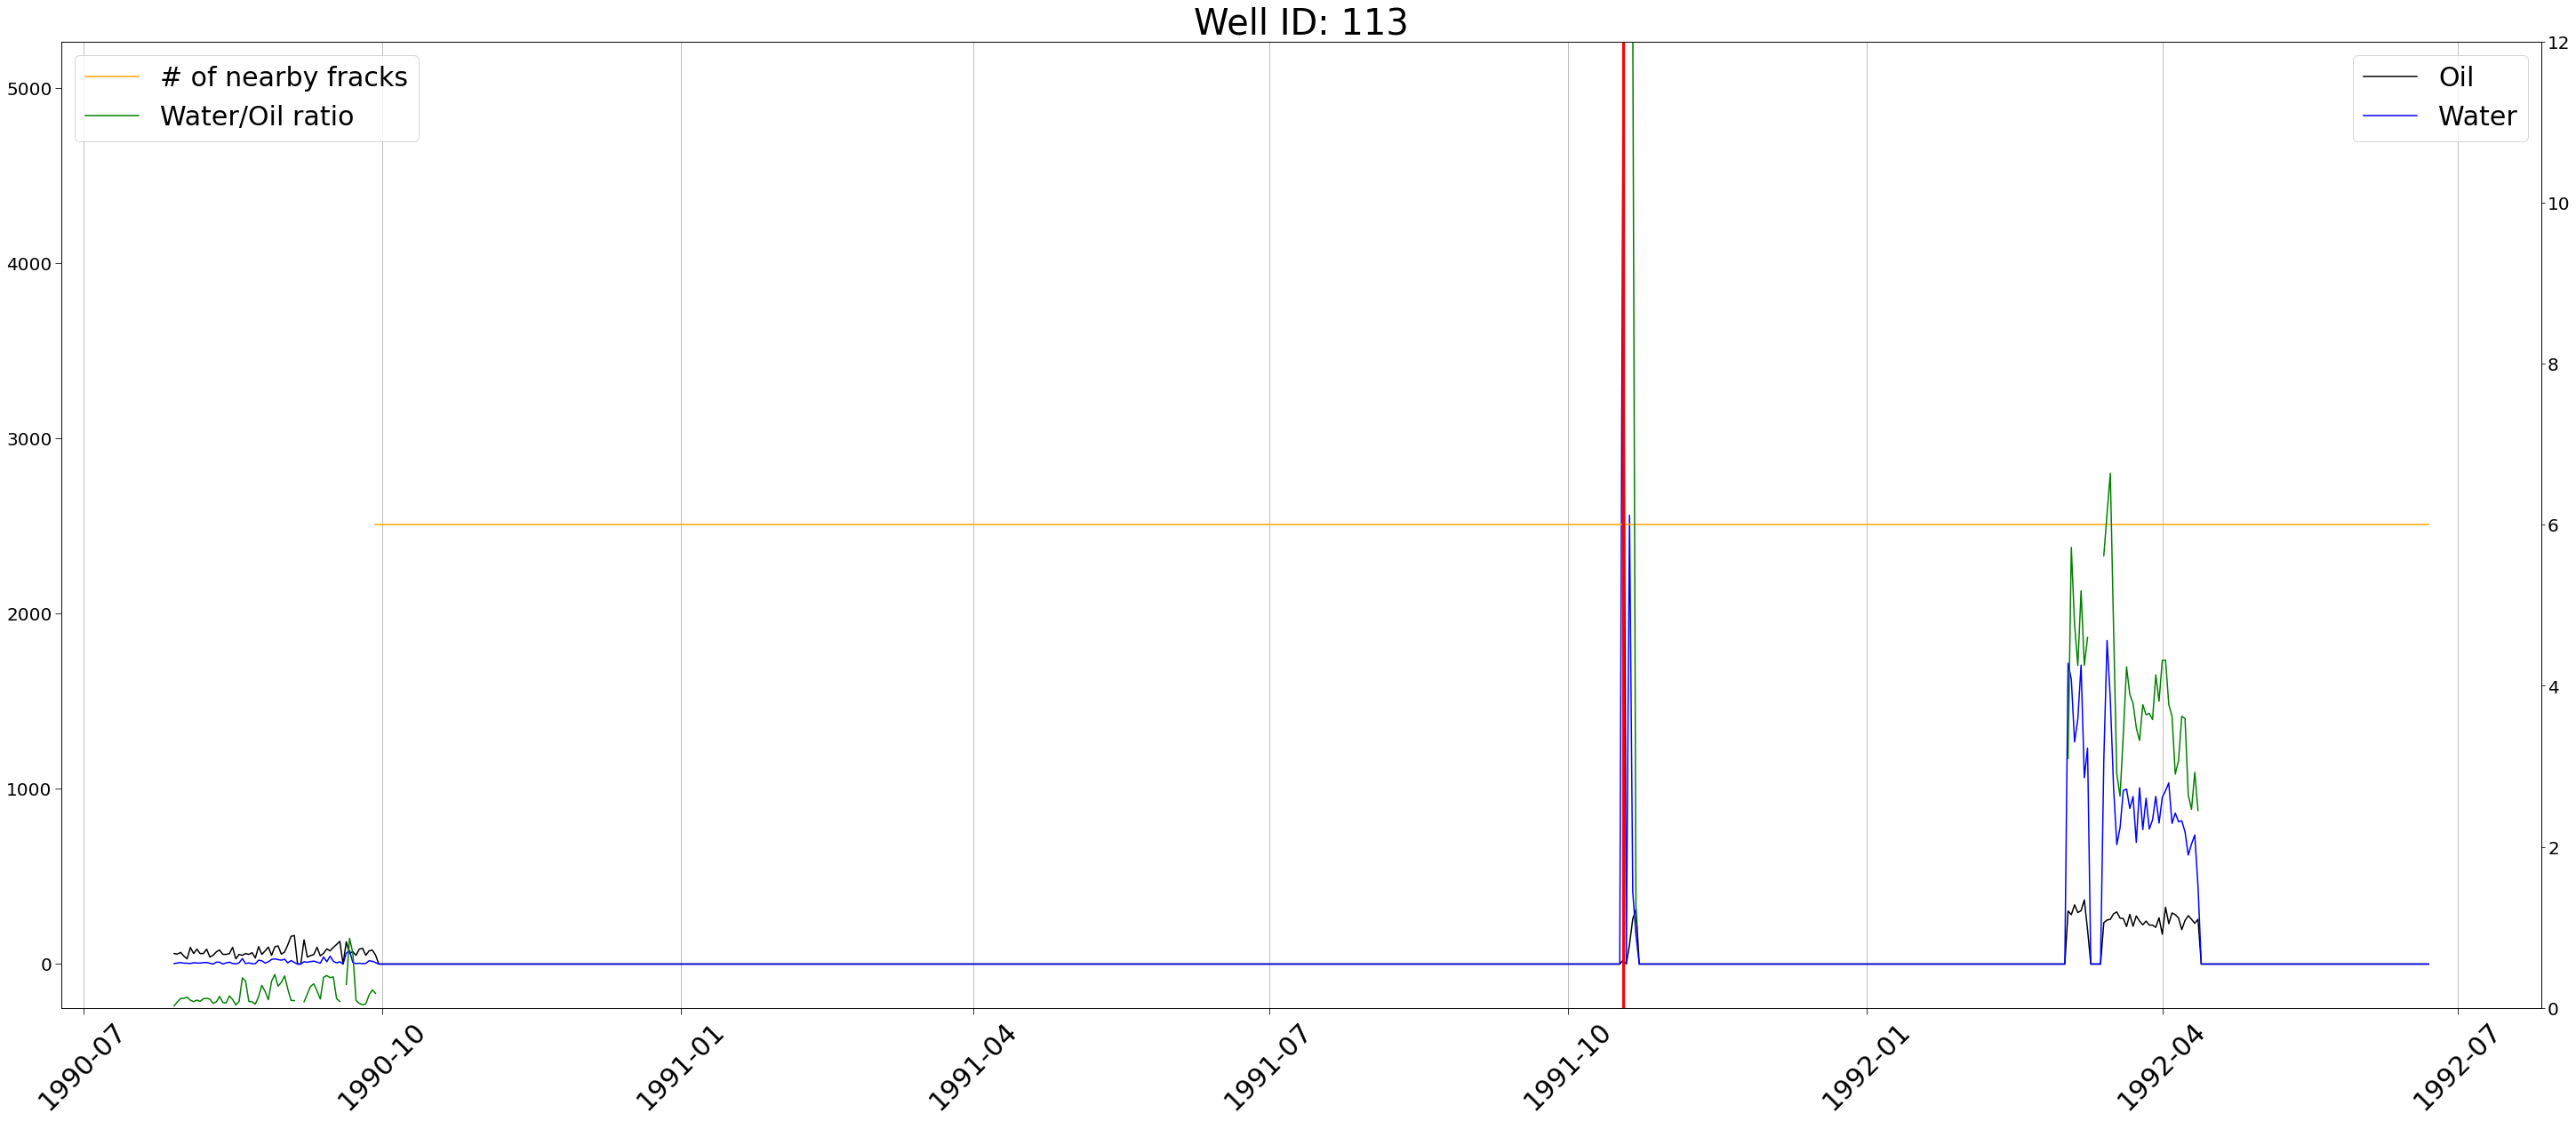

In [113]:
#plotfrackhit(productiondataset with windows, frackhit date and well, days before frack hit (negative #), days after frack hit)

#Index of frack hit in frackhits dataframe
i=34
showfrackhitplot(charDF, frackhits.iloc[i], -80, 30)

#Save plot to file
#plotfilename = '.png'
#savefrackhitplot(plotfilename, charDF, frackhits.iloc[i], -80, 30)

# supporting graphs for data diving

In [16]:
def StdDevfracgraph(df,startdate, enddate, offset=offset, sw=smallwindow, bw=bigwindow, meanmult = 1.5, stddevmult=.0501):
    df = df[(df['Date']>= startdate) & (df['Date']<=enddate)].sort_values(by='Date')
    x = df['Date']
    y1 = df['BOE']
    y2 = df['nearbyfracks at {}_ext'.format(offset)]
    ywat = df['Water']
    y3 = df['Water/Oil {}-day mean'.format(sw)]
    thresh = df['Water {}-day mean'.format(bw)]*meanmult+\
        df['Water {}-day std'.format(bw)]* df['Water {}-day mean'.format(sw)]*stddevmult
    stddev = df['Water {}-day std'.format(bw)]
    mean = df['Water {}-day mean'.format(bw)]

    fig, ax1 = plt.subplots(figsize=(50,20))
    plt.xticks(fontsize=30, rotation=45)
    plt.yticks(fontsize=20)
    ax1.set_ylim([0,max(y1.max(),ywat.max())])
    ax1.plot(x, y1,'black', label='Oil')
    ax1.plot(x, ywat, 'blue', label = 'Water')
    ax1.plot(x,thresh,'red', label = 'threshold')
    ax1.plot(x,stddev,'purple', label = 'stddev')
    ax1.plot(x,mean,'green', label = 'Water mean')
    ax1.xaxis.grid(True, which='both')
    ax1.tick_params(which='major', length=7)
    ax1.tick_params(which='minor', width=2, length = 4, color = 'r')
    ax1.legend(loc=2, prop={'size': 30})
    
    ax3 = ax1.twinx()
    ax3.plot(x, y2, 'orange', label = 'nearbyfracks at {}'.format(offset))
    ax3.set_ylim([0,y2.max() * 3])
    plt.show()
    
def basicplot(df, wellid, centraldate, startpad = -40, endpad = 40, offset=offset):
    df = df[df.WellID==wellid].sort_values(by='Date').copy()
    startdate = centraldate + pd.Timedelta(days=startpad)
    enddate = centraldate + pd.Timedelta(days=endpad)
    df = df[(df['Date']>= startdate) & (df['Date']<=enddate)]

    x = df['Date']
    y1 = df['Oil']
    y2 = df['nearbyfracks at {}'.format(offset)]
    y3 = df['Water']

    fig, ax1 = plt.subplots(figsize=(50,20))
    plt.xticks(fontsize=30, rotation=45)
    plt.yticks(fontsize=20)
    ax2 = ax1.twinx()
    plt.title('Well ID: {}'.format(df.WellID.max()), fontdict= {'fontsize':40})
    plt.ylim(0,max(y1.max(),y3.max()))
    ax1.plot(x, y1, 'black')
    ax1.plot(x, y3, 'blue')
    ax1.xaxis.grid(True, which='both')
    ax1.tick_params(which='major', length=7)

    ax2.plot(x, y2, 'orange')
    plt.yticks(fontsize=20)
    ax2.set_ylim([0,y2.max() * 2])
    plt.show()

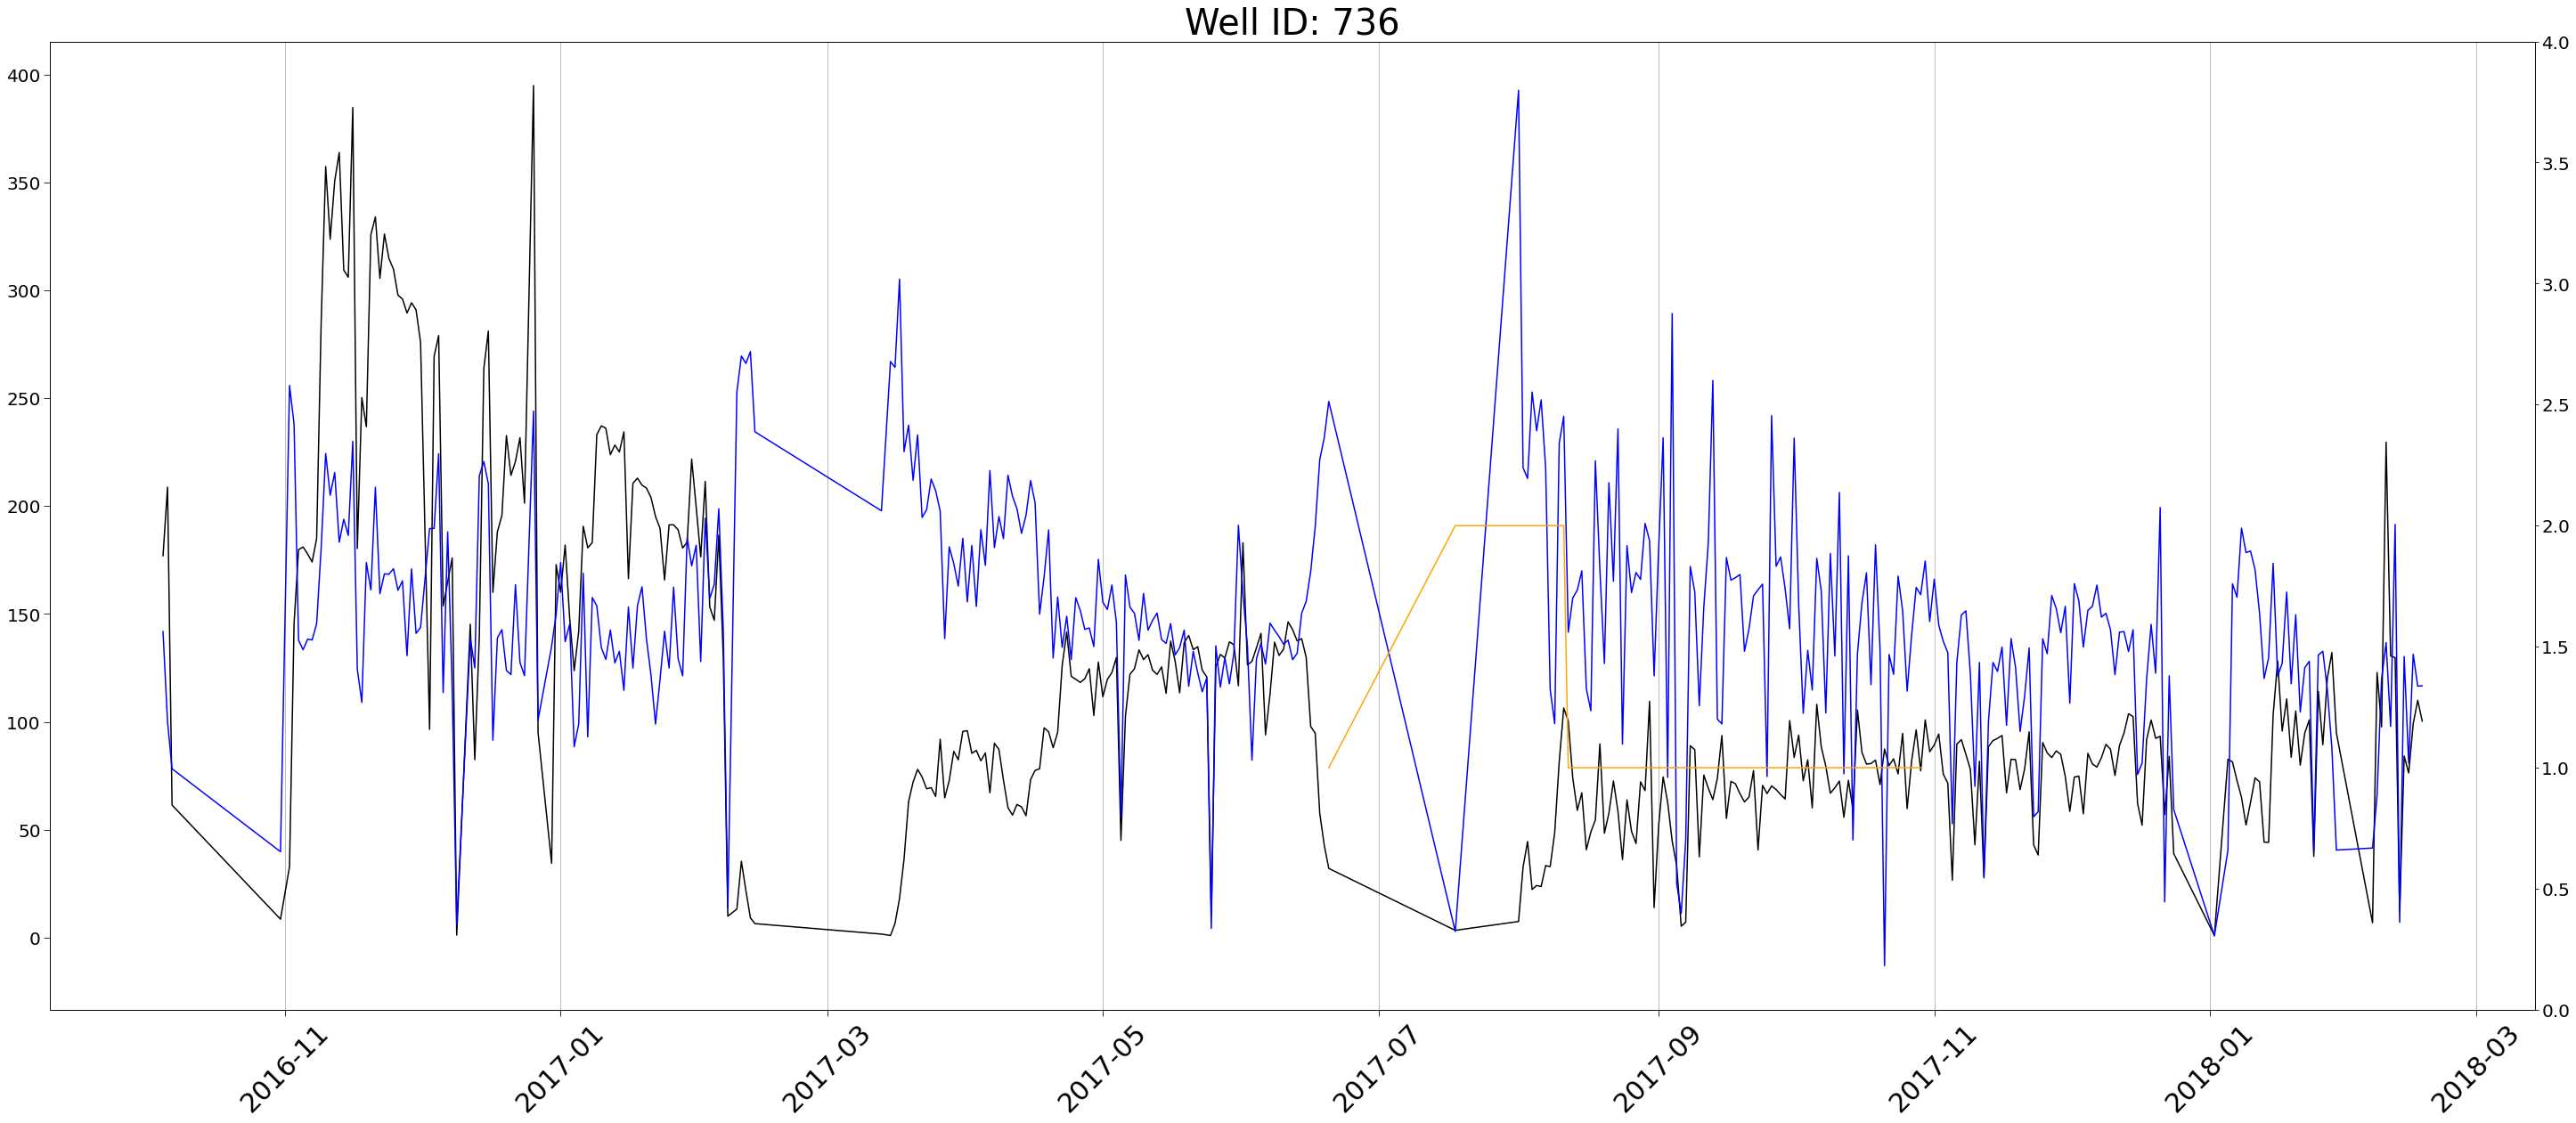

In [25]:
basicplot(prodwfracks, 736, pd.to_datetime('2017-08-01') , -300,200)